## Forecasting Ralph Lauren Stock Prices

### Importing neccessary libraries

In [1]:
import yfinance as yf
import datetime
from fredapi import Fred
from fred_key import fred_key
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf 
from pandas import Grouper
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.graphics.gofplots import qqplot 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from math import sqrt

### Downloading Stocks from Ralph Lauren

In [2]:
rl_stock = yf.download('RL', start='2015-01-01', end=datetime.date.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
rl_stock.head()

Price,Close,High,Low,Open,Volume
Ticker,RL,RL,RL,RL,RL
Date,,,,,
2015-01-02,149.258942,152.169118,147.881290,151.606643,503400
2015-01-05,145.003738,147.139499,144.139652,146.552570,1761800
2015-01-06,142.175079,145.501004,141.229471,145.134165,1486500
2015-01-07,145.737411,145.835229,143.063631,143.202209,620400
2015-01-08,145.566238,146.381416,144.359767,144.857026,790700


In [4]:
rl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2533 entries, 2015-01-02 to 2025-01-28
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (Close, RL)   2533 non-null   float64
 1   (High, RL)    2533 non-null   float64
 2   (Low, RL)     2533 non-null   float64
 3   (Open, RL)    2533 non-null   float64
 4   (Volume, RL)  2533 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.7 KB


In [5]:
rl_stock.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in rl_stock.columns]
rl_stock.reset_index(inplace=True)  

In [6]:
rl_stock.head()

,Date,Close_RL,High_RL,Low_RL,Open_RL,Volume_RL
0,2015-01-02,149.258942,152.169118,147.881290,151.606643,503400
1,2015-01-05,145.003738,147.139499,144.139652,146.552570,1761800
2,2015-01-06,142.175079,145.501004,141.229471,145.134165,1486500
3,2015-01-07,145.737411,145.835229,143.063631,143.202209,620400
4,2015-01-08,145.566238,146.381416,144.359767,144.857026,790700


In [7]:
rl_stock = rl_stock[['Date', 'Close_RL']]

In [8]:
rl_stock.head()

,Date,Close_RL
0,2015-01-02,149.258942
1,2015-01-05,145.003738
2,2015-01-06,142.175079
3,2015-01-07,145.737411
4,2015-01-08,145.566238


#### Hypothesis

Economic factors influencing these stock prices:
1. Imports and Tariff:
Ralph Lauren, like many other fashion companies, sources materials and produces goods globally. Trade conflicts, such as U.S.-China tensions or changes in import tariffs, could impact their supply chain costs and profitability. For instance, a tariff on cotton, imported fabric, or apparel could drive up production costs, potentially reducing profit and affecting stock performance. To assess this, we can analyze the trends in the import of goods and services.

2. Currency Fluctuations: 
Since Ralph Lauren's products are sold internationally, fluctuations in exchange rates can influence the cost of goods sold in foreign markets, ultimately impacting revenue. For instance, a stronger U.S. dollar can make their products more expensive abroad, potentially reducing demand in international markets, affecting their overall profit.

3. Consumer Confidence: 
The Consumer Confidence Index (CCI) is a survey that measures how consumers feel about the economy, their finances, and their expectations for the future. The CCI helps predict how consumers will spend money, which can stimulate or slow down the economy. This can overall affect sales of Ralph Lauren products, since customers feeling confident about the economy will urge them into spending good money on luxury items. Conversely, lower confidence could lessen demand for non-essential items, also influencing the company’s revenue.


#### Sourcing data to test the hypothesis

1. Using the FRED (Federal Reserve Economic Data) API to get data on the import of good and services
2. Forex rates obtained from the Yahoo Finance
3. Using the FRED API to get data on the Customer Confidence Index

** Using an API instead of importing a CSV so that whenever the code is run, the data stays up to date. **

#### Importing Data of Goods and Services Import

In [9]:
fred = Fred(api_key=fred_key)

In [10]:
imports_data = fred.get_series('IMPGS')
imports_data = pd.DataFrame(imports_data, columns=['Imports'])

imports_data = imports_data.reset_index().rename(columns={'index': 'Date'})
imports_data['Date'] = pd.to_datetime(imports_data['Date'])

start_date = '2015-01-01'
imports_data = imports_data[imports_data['Date'] >= start_date]

imports_data = imports_data.reset_index(drop=True)

In [11]:
imports_data.head()

,Date,Imports
0,2015-01-01,2825.476
1,2015-04-01,2809.968
2,2015-07-01,2798.806
3,2015-10-01,2745.517
4,2016-01-01,2693.639


#### Importing EUR to USD exchange rates

In [12]:
exchange_rate_data = yf.download('USDINR=X', start='2015-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [13]:
exchange_rate_data.head()

Price,Close,High,Low,Open,Volume
Ticker,USDINR=X,USDINR=X,USDINR=X,USDINR=X,USDINR=X
Date,,,,,
2015-01-01,63.028000,63.090000,63.028000,63.028000,0
2015-01-02,63.028000,63.459999,62.900002,63.090000,0
2015-01-05,63.278000,63.480000,63.169998,63.278000,0
2015-01-06,63.338001,63.618000,63.250000,63.338001,0
2015-01-07,63.568001,63.580002,63.150002,63.470001,0


In [14]:
exchange_rate_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in exchange_rate_data.columns]
exchange_rate_data.reset_index(inplace=True)  

In [15]:
exchange_rate_data.head()

,Date,Close_USDINR=X,High_USDINR=X,Low_USDINR=X,Open_USDINR=X,Volume_USDINR=X
0,2015-01-01,63.028000,63.090000,63.028000,63.028000,0
1,2015-01-02,63.028000,63.459999,62.900002,63.090000,0
2,2015-01-05,63.278000,63.480000,63.169998,63.278000,0
3,2015-01-06,63.338001,63.618000,63.250000,63.338001,0
4,2015-01-07,63.568001,63.580002,63.150002,63.470001,0


In [16]:
exchange_rate_data = exchange_rate_data[['Date', 'Close_USDINR=X']]

In [17]:
exchange_rate_data.head()

,Date,Close_USDINR=X
0,2015-01-01,63.028000
1,2015-01-02,63.028000
2,2015-01-05,63.278000
3,2015-01-06,63.338001
4,2015-01-07,63.568001


#### Importing Consumer Confidence Interval data

In [18]:
cci_data = fred.get_series('UMCSENT')
cci_data = pd.DataFrame(cci_data, columns=['CCI'])

cci_data = cci_data.reset_index().rename(columns={'index': 'Date'})
cci_data['Date'] = pd.to_datetime(cci_data['Date'])

start_date = '2015-01-01'
cci_data = cci_data[cci_data['Date'] >= start_date]

cci_data = cci_data.reset_index(drop=True)

In [19]:
cci_data.head()

,Date,CCI
0,2015-01-01,98.1
1,2015-02-01,95.4
2,2015-03-01,93.0
3,2015-04-01,95.9
4,2015-05-01,90.7


### Performing EDA

In [20]:
# Merging the stock price data with the economic factors data 

merged_data = (
    rl_stock.merge(imports_data, on='Date', how='outer')
            .merge(exchange_rate_data, on='Date', how='outer')
            .merge(cci_data, on='Date', how='outer')
)

merged_data = merged_data.reset_index(drop=True)

In [21]:
merged_data.set_index('Date', inplace=True)

In [22]:
merged_data.head()

,Close_RL,Imports,Close_USDINR=X,CCI
Date,,,,
2015-01-01,NaN,2825.476,63.028000,98.1
2015-01-02,149.258942,NaN,63.028000,NaN
2015-01-05,145.003738,NaN,63.278000,NaN
2015-01-06,142.175079,NaN,63.338001,NaN
2015-01-07,145.737411,NaN,63.568001,NaN


In [23]:
merged_data.describe()

,Close_RL,Imports,Close_USDINR=X,CCI
count,2533.000000,39.000000,2625.000000,120.000000
mean,105.059321,3259.504692,72.939749,83.192500
std,33.321758,498.205310,6.913612,14.289011
min,55.823246,2350.926000,61.351002,50.000000
25%,83.939117,2849.312000,66.818100,70.450000
50%,101.046242,3117.952000,72.470001,89.050000
75%,113.163605,3821.067500,79.368401,96.125000
max,257.450012,4163.975000,86.650597,101.400000


<Axes: >

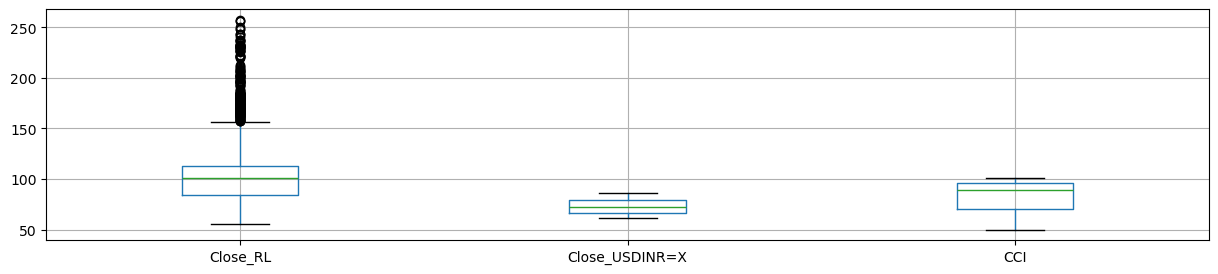

In [24]:
plt.figure(figsize=(15, 3))
merged_data.drop(columns=['Imports']).boxplot()

# Leaving Imports out of this plot, and plotting it separately since the scale for Import is much larger than the other elements.

<Axes: >

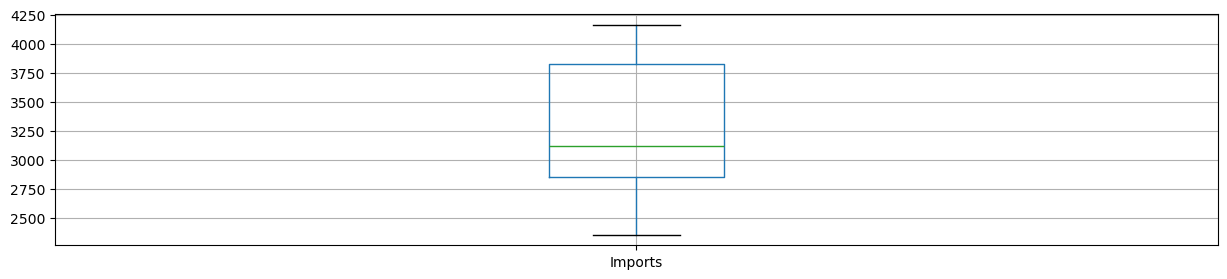

In [25]:
plt.figure(figsize=(15, 3)) 
merged_data[['Imports']].boxplot()

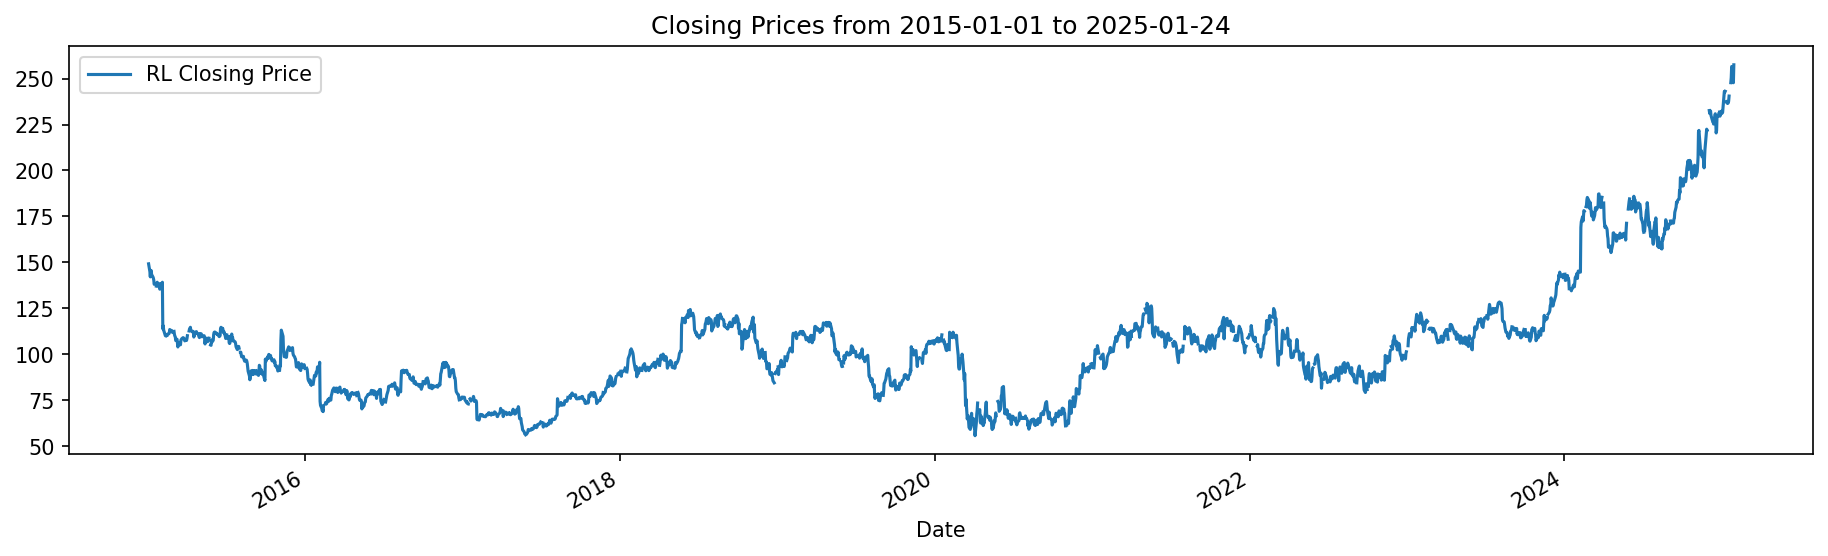

In [26]:
plt.figure(figsize=(15, 4), dpi=150)

merged_data['Close_RL'].plot(label='RL Closing Price')

plt.title('Closing Prices from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### Price variations for each year

<Axes: xlabel='Date', ylabel='Close_RL'>

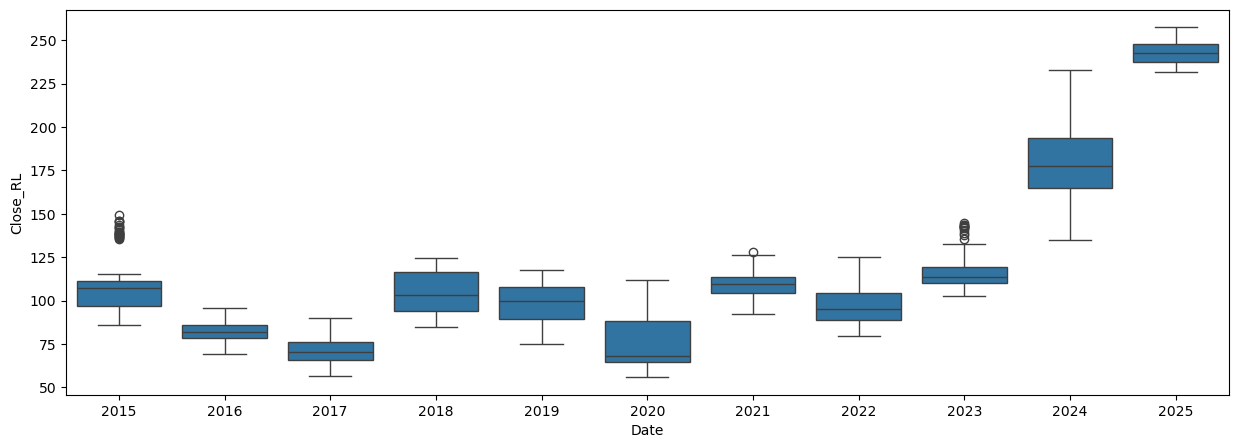

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=merged_data.index.year, y=merged_data['Close_RL'], ax=ax)

##### Price variations for each month

<Axes: xlabel='Date', ylabel='Close_RL'>

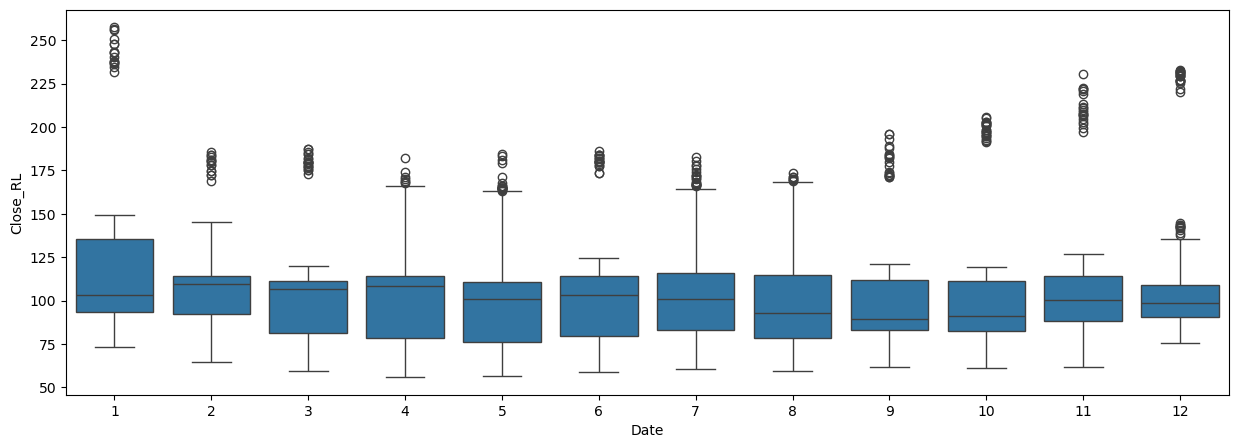

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x = merged_data.index.month,
                y = merged_data['Close_RL'],
                ax = ax)

### Handling Missing Values

In [29]:
merged_data.isna().sum()

Close_RL           128
Imports           2622
Close_USDINR=X      36
CCI               2541
dtype: int64

In [30]:
merged_data = merged_data.reindex(pd.date_range('2015-01-01', datetime.datetime.today()))

##### Testing different imputation methods for Imports and CCI since they were recorded Quarterly / Monthly

##### Spline Interpolation:

In [31]:
merged_data_imputed_imports = merged_data[['Imports']].copy()
merged_data_imputed_cci = merged_data[['CCI']].copy()

merged_data_imputed_imports['Imports'] = merged_data_imputed_imports['Imports'].interpolate(method='spline', order=1, limit=250, limit_direction='both')
merged_data_imputed_cci['CCI'] = merged_data_imputed_cci['CCI'].interpolate(method='spline', order=1, limit=15, limit_direction='both')

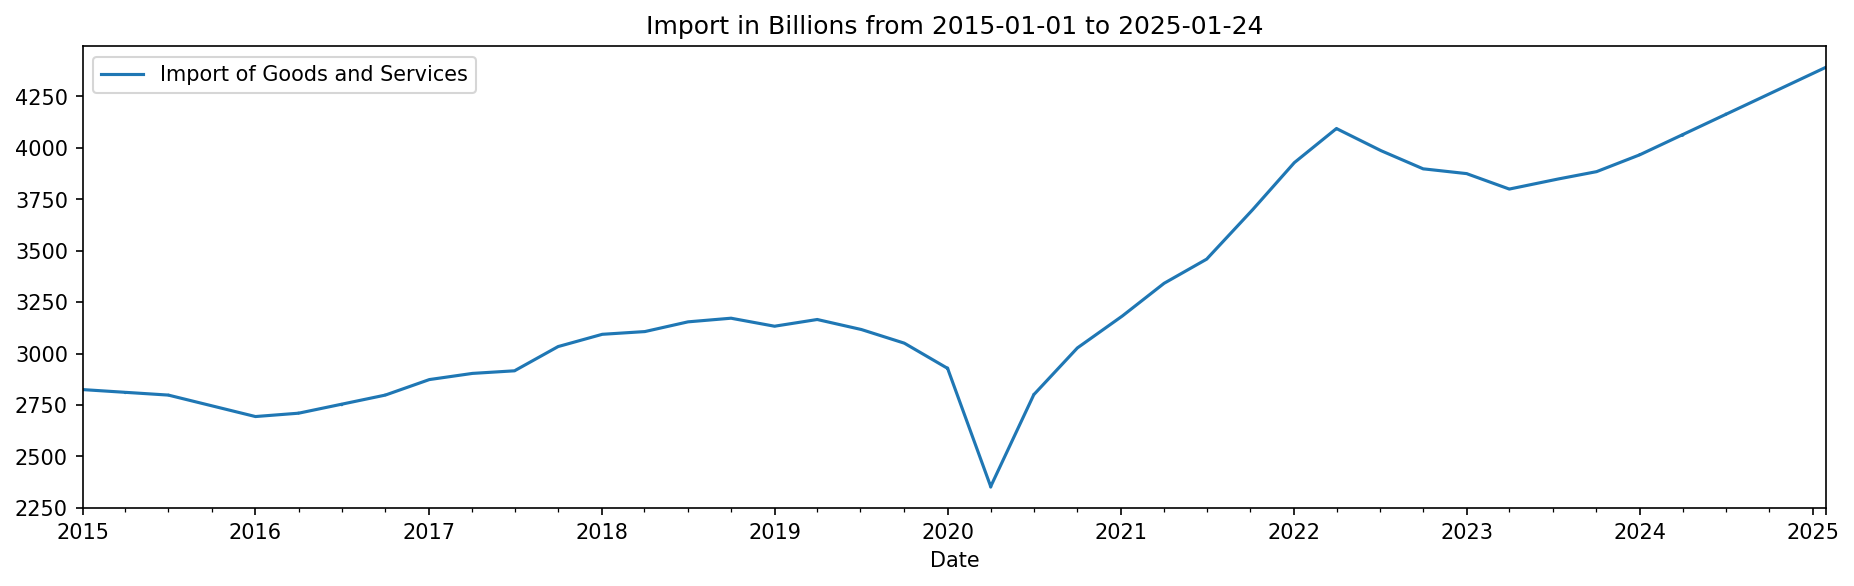

In [32]:
plt.figure(figsize=(15, 4), dpi=150)

merged_data_imputed_imports['Imports'].plot(label='Import of Goods and Services')

plt.title('Import in Billions from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

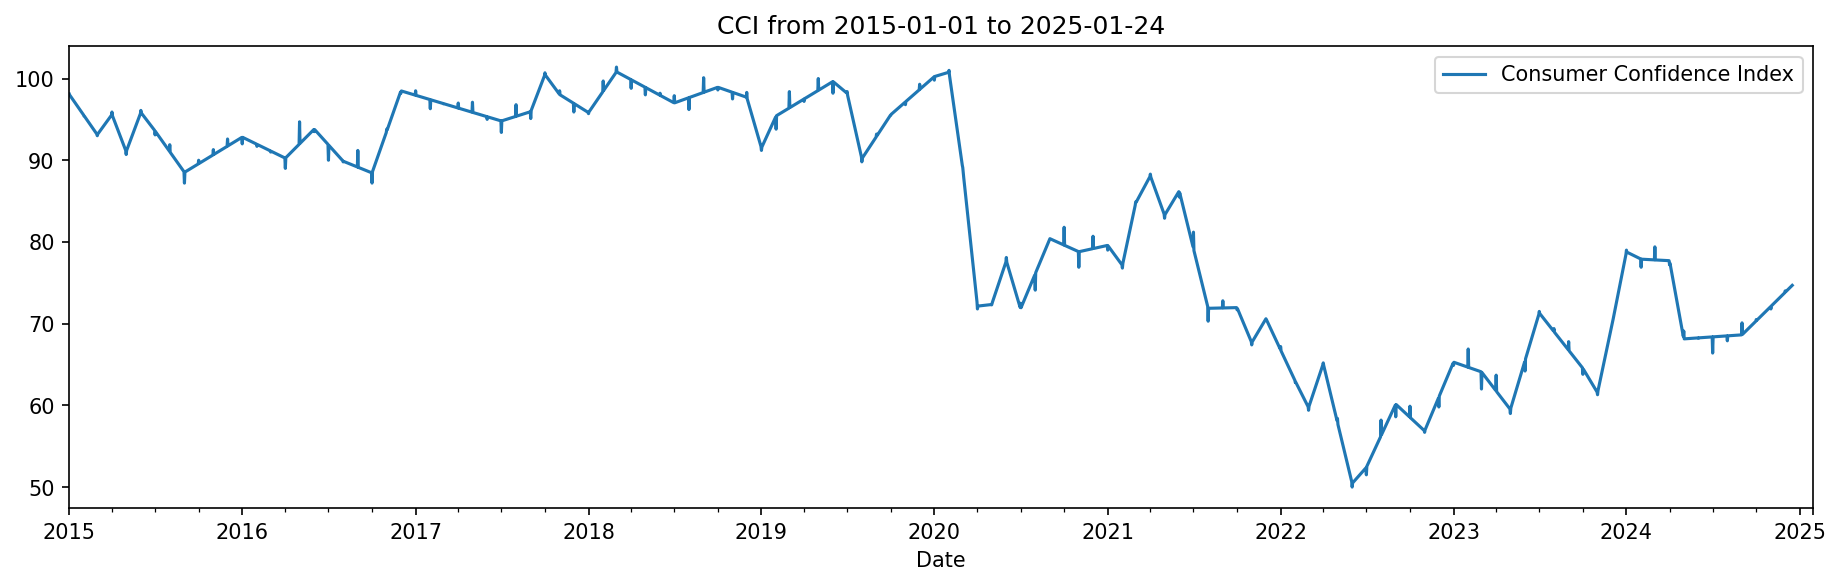

In [33]:
plt.figure(figsize=(15, 4), dpi=150)

merged_data_imputed_cci['CCI'].plot(label='Consumer Confidence Index')

plt.title('CCI from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### Forward Fill

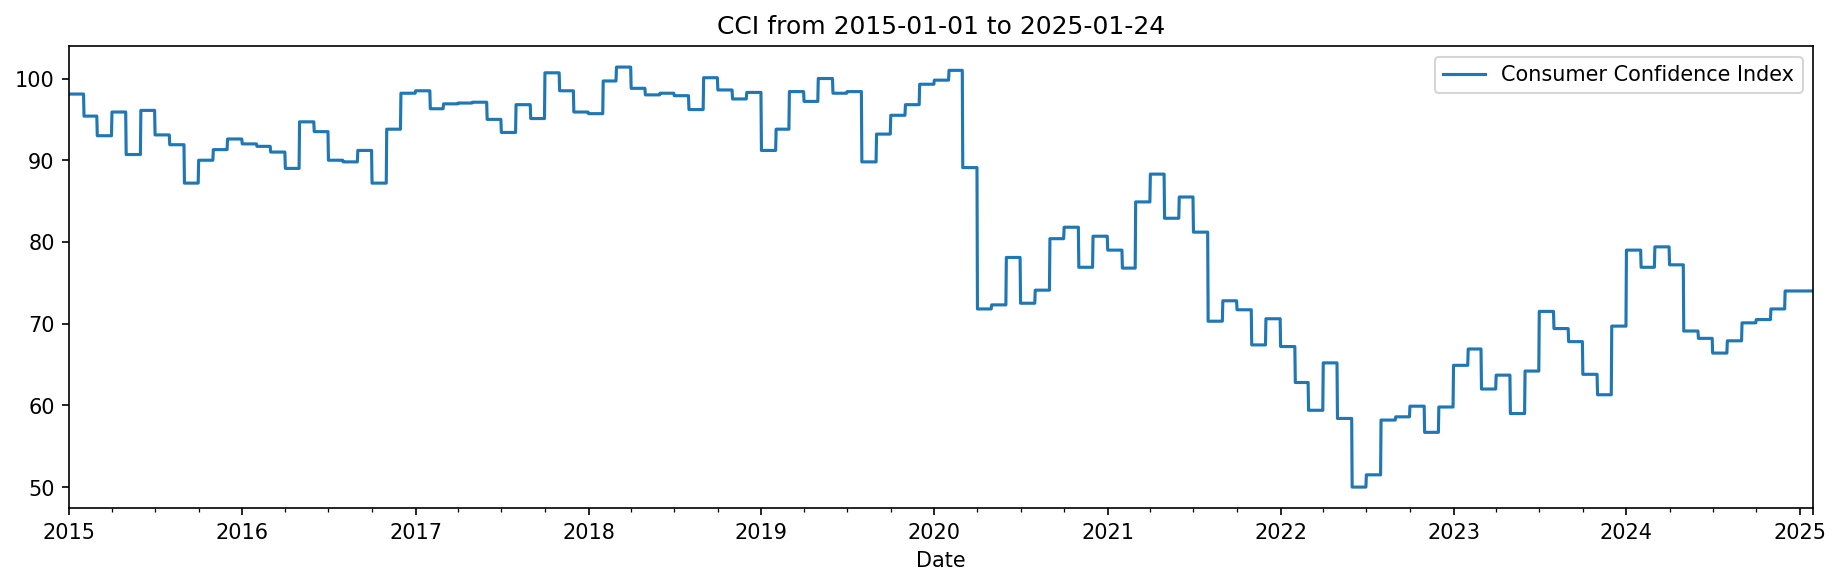

In [34]:
merged_data_imputed_cci = merged_data[['CCI']].copy()
merged_data_imputed_cci['CCI']= merged_data_imputed_cci['CCI'].ffill()

plt.figure(figsize=(15, 4), dpi=150)

merged_data_imputed_cci['CCI'].plot(label='Consumer Confidence Index')

plt.title('CCI from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### Piecewise Linear Interpolation

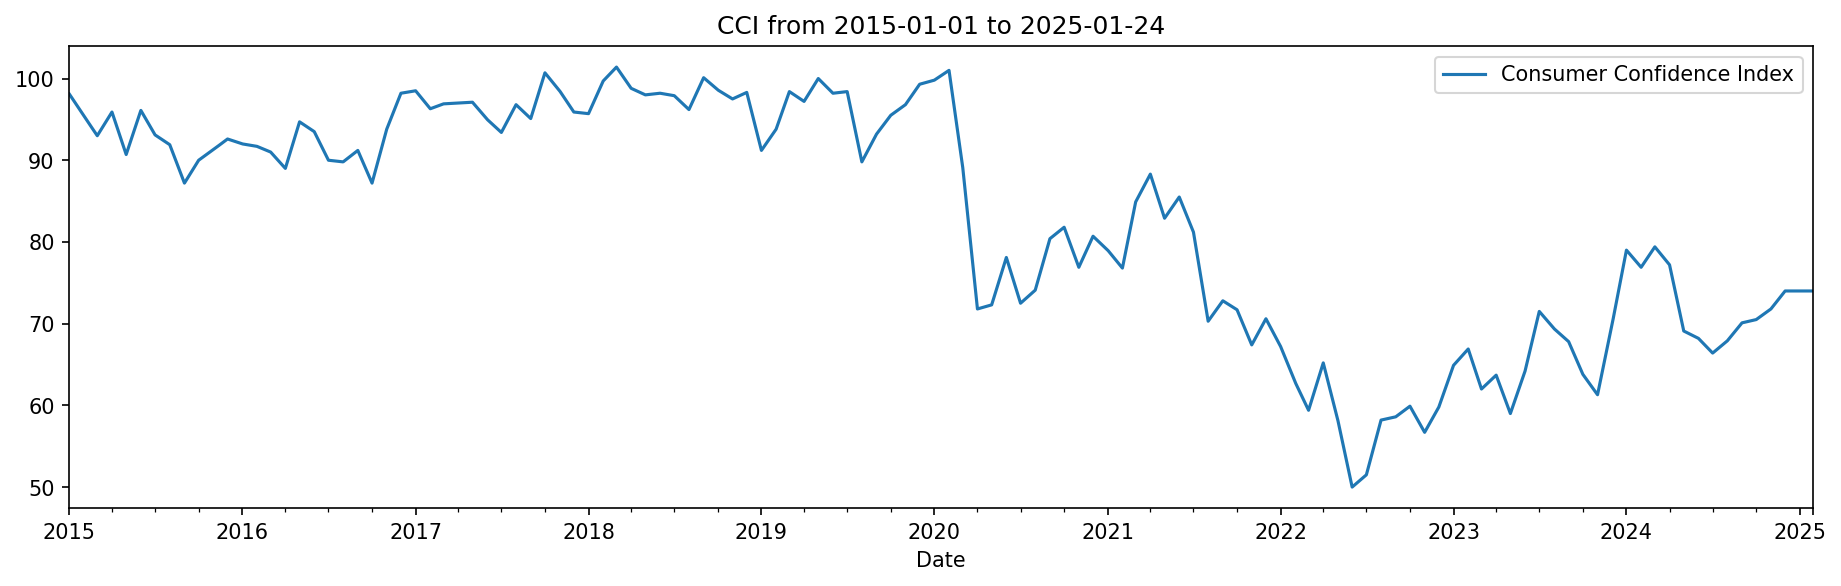

In [35]:
merged_data_imputed_cci = merged_data[['CCI']].copy()
merged_data_imputed_cci['CCI'] = merged_data_imputed_cci['CCI'].interpolate(method='linear')

plt.figure(figsize=(15, 4), dpi=150)

merged_data_imputed_cci['CCI'].plot(label='Consumer Confidence Index')

plt.title('CCI from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### Resampling Imports and CCI into Daily Data

In [36]:
df_resample = merged_data.copy()

df_resample = df_resample[['Imports', 'CCI']].round(2)
df_resample.head()

,Imports,CCI
2015-01-01,2825.48,98.1
2015-01-02,NaN,NaN
2015-01-03,NaN,NaN
2015-01-04,NaN,NaN
2015-01-05,NaN,NaN


In [37]:
df_daily = df_resample.resample('D').interpolate()
df_daily.head()

,Imports,CCI
2015-01-01,2825.480000,98.100000
2015-01-02,2825.307667,98.012903
2015-01-03,2825.135333,97.925806
2015-01-04,2824.963000,97.838710
2015-01-05,2824.790667,97.751613


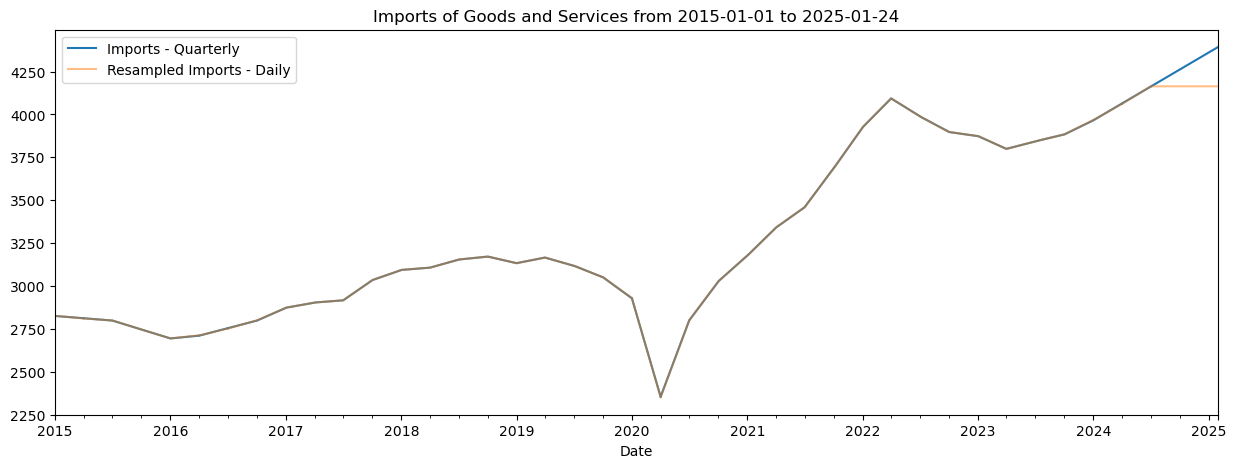

In [38]:
plt.figure(figsize=(15, 5))

merged_data_imputed_imports['Imports'].plot(label='Imports - Quarterly')
df_daily['Imports'].plot(label='Resampled Imports - Daily', alpha=0.5)

plt.title('Imports of Goods and Services from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

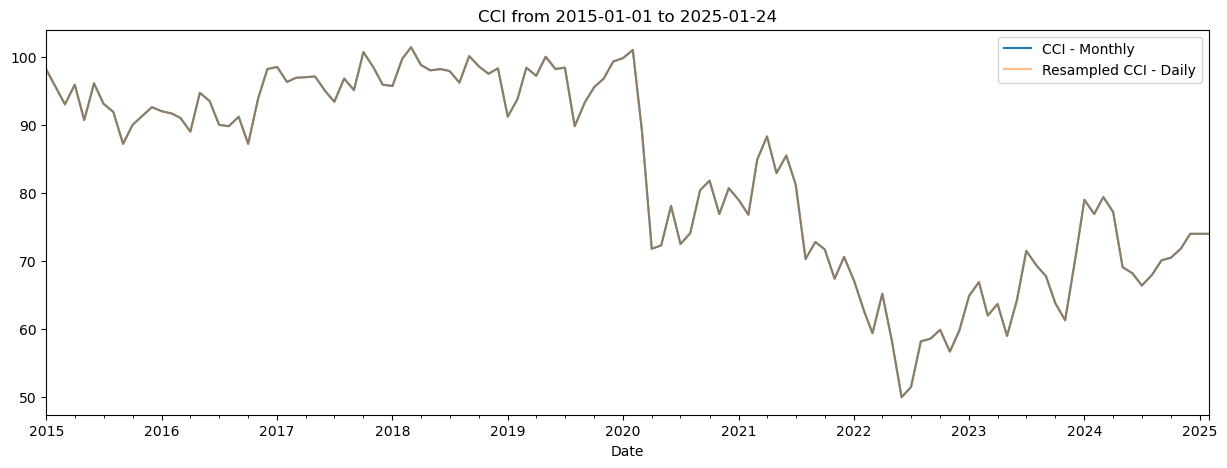

In [39]:
plt.figure(figsize=(15, 5))

merged_data_imputed_cci['CCI'].plot(label='CCI - Monthly')
df_daily['CCI'].plot(label='Resampled CCI - Daily', alpha=0.5)

plt.title('CCI from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### The two plots appear to have only one single line because the imputed data using Spline Interpolation (Imports) and Piecewise Linear Interpolation (CCI) is almost exactly identical to the results from the up-sampled data.

In [40]:
# Handling the missing values based on inferences above

merged_data['Close_RL']= merged_data['Close_RL'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
merged_data['Imports'] = merged_data['Imports'].interpolate(method='spline', order=1, limit=250, limit_direction='both')
merged_data['Close_USDINR=X']= merged_data['Close_USDINR=X'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
merged_data['CCI'] = merged_data['CCI'].interpolate(method='linear')

In [41]:
merged_data.isna().sum()

Close_RL          0
Imports           0
Close_USDINR=X    0
CCI               0
dtype: int64

### Exploring the Relationship Between Economic Factors Influence on the Stock Prices

In [42]:
# Scaling the Economic factors to visualize it better

merged_data_scaled = merged_data.copy()

merged_data_scaled['Imports'] = merged_data_scaled['Imports'] / 1e1
merged_data_scaled['CCI'] = merged_data_scaled['CCI'] * 2.5

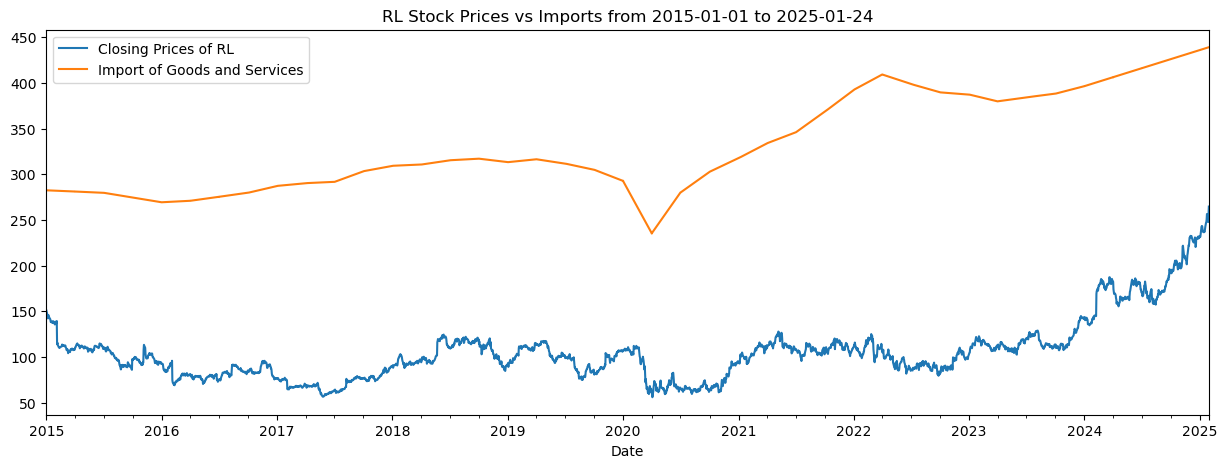

In [43]:
plt.figure(figsize=(15, 5))

merged_data['Close_RL'].plot(label='Closing Prices of RL')
merged_data_scaled['Imports'].plot(label='Import of Goods and Services')

plt.title('RL Stock Prices vs Imports from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

#### The plot indicates that imports only align with Ralph Lauren's stock prices during 2020, likely due to the pandemic, which significantly hindered global trade and supply chains. Although, outside of this period, there appears to be an upward trend in the import of goods and services, with no consistent relationship to stock price fluctuations. So, it is safe to say that the import of goods and services is not a reliable predictor for Ralph Lauren's stock prices.

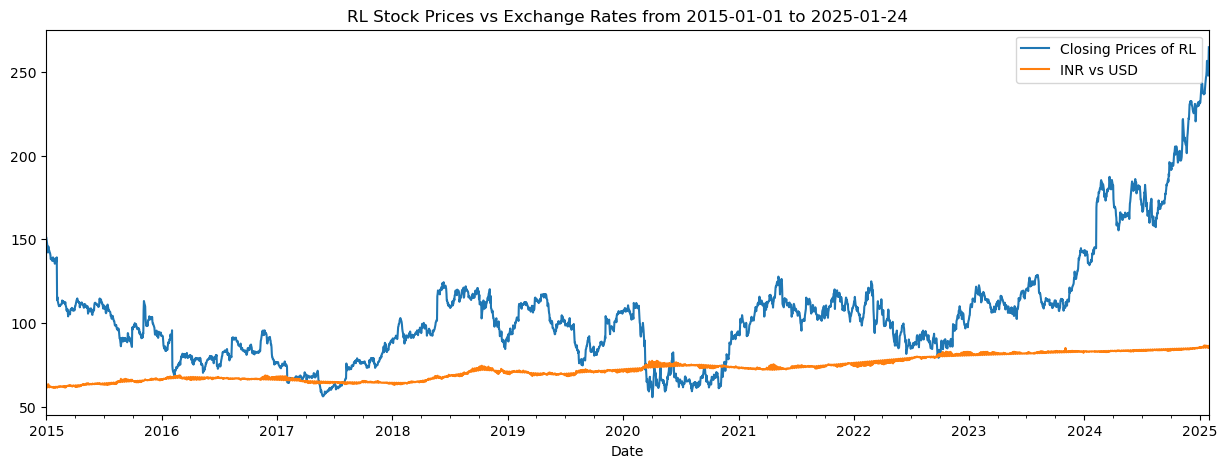

In [44]:
plt.figure(figsize=(15, 5))

merged_data['Close_RL'].plot(label='Closing Prices of RL')
merged_data_scaled['Close_USDINR=X'].plot(label='INR vs USD')

plt.title('RL Stock Prices vs Exchange Rates from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

#### The currency exchange rate from USD to INR shows almost no discernible trend, making it unsuitable for predicting Ralph Lauren stock prices. This indicates that fluctuations in this exchange rate likely have minimal direct impact on the company's stock performance.

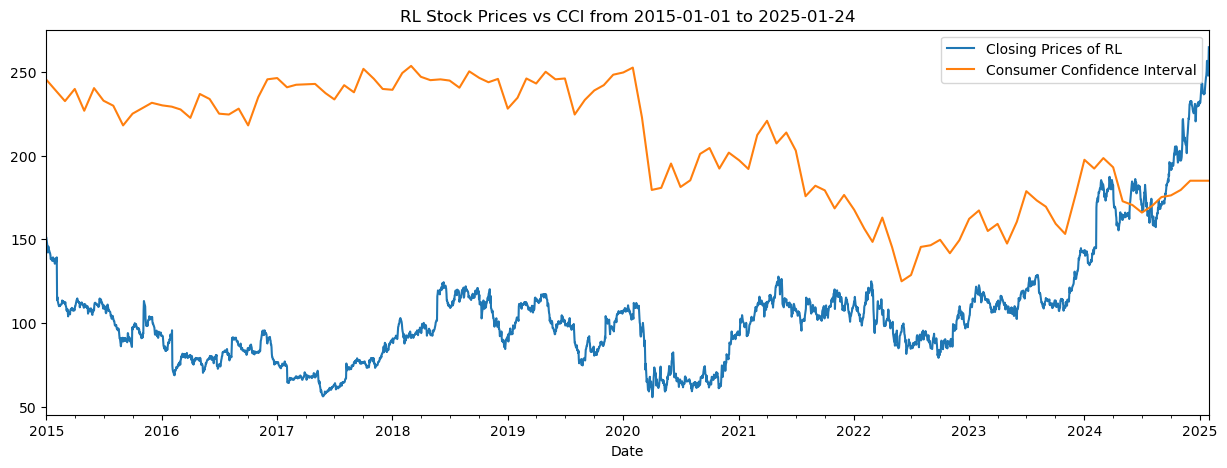

In [45]:
plt.figure(figsize=(15, 5))

merged_data['Close_RL'].plot(label='Closing Prices of RL')
merged_data_scaled['CCI'].plot(label='Consumer Confidence Interval')

plt.title('RL Stock Prices vs CCI from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

#### Starting from around 2019, the CCI graph closely mimics the fluctuations in Ralph Lauren's stock prices, suggesting that CCI might be a good factor for forecasting stock prices. However, a correlation test would provide a more reliable assessment of this relationship, since visual patterns alone can sometimes be misleading

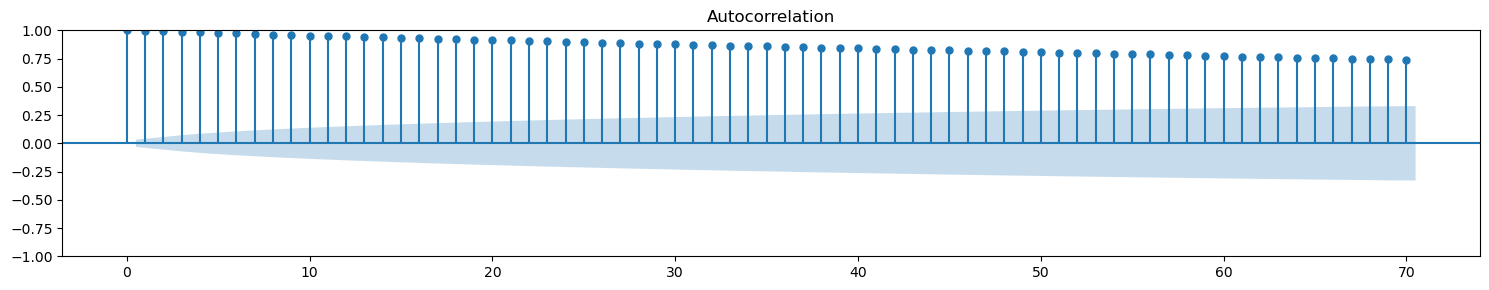

In [46]:
fig = plot_acf(merged_data['Close_RL'], lags=70)
fig.set_size_inches((15, 3))

fig.tight_layout()
plt.show()

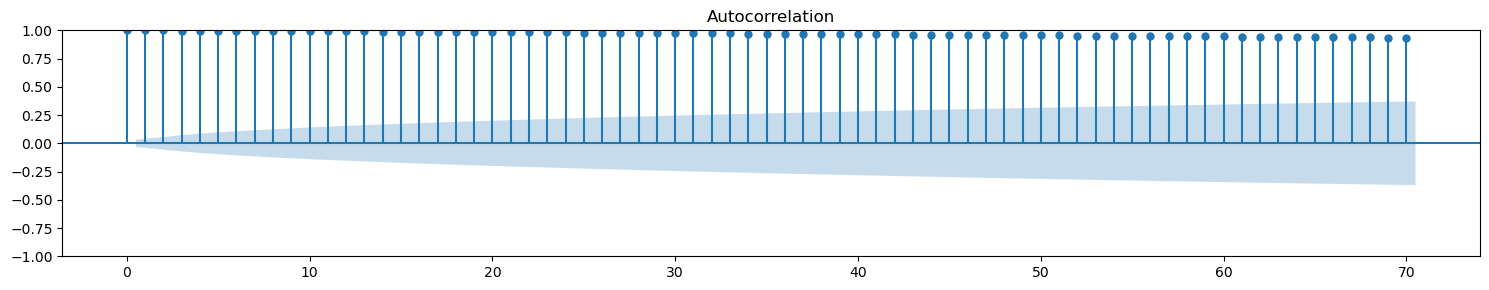

In [47]:
fig = plot_acf(merged_data['Imports'], lags=70)
fig.set_size_inches((15, 3))

fig.tight_layout()
plt.show()

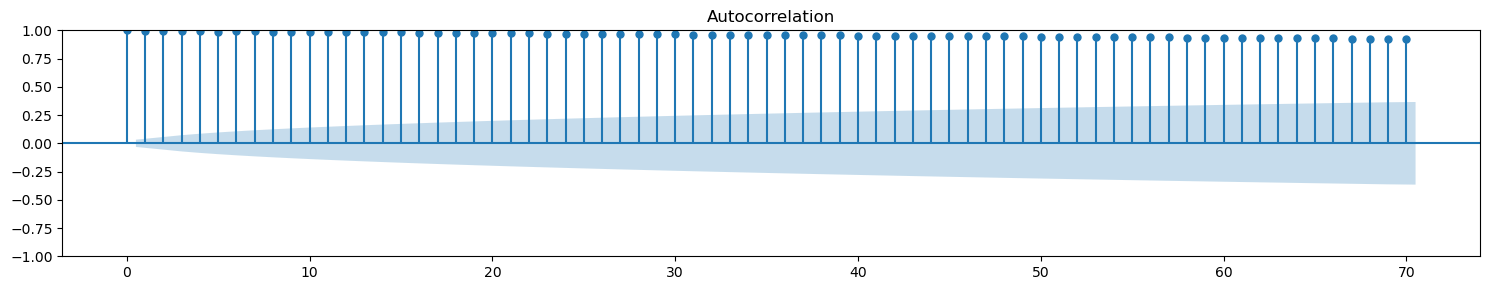

In [48]:
fig = plot_acf(merged_data['Close_USDINR=X'], lags=70)
fig.set_size_inches((15, 3))

fig.tight_layout()
plt.show()

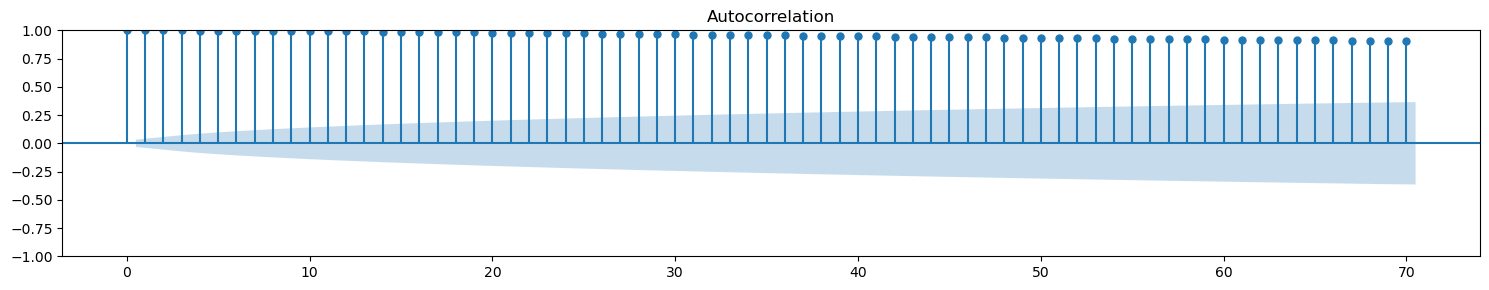

In [49]:
fig = plot_acf(merged_data['CCI'], lags=70)
fig.set_size_inches((15, 3))

fig.tight_layout()
plt.show()

##### Observing the ACF plots above, it is clear that none of the chosen economic factors are just white noise.

##### Re-sampling the Data into Monthly Data

In [50]:
merged_data = merged_data.groupby(pd.Grouper(freq='MS')).median()

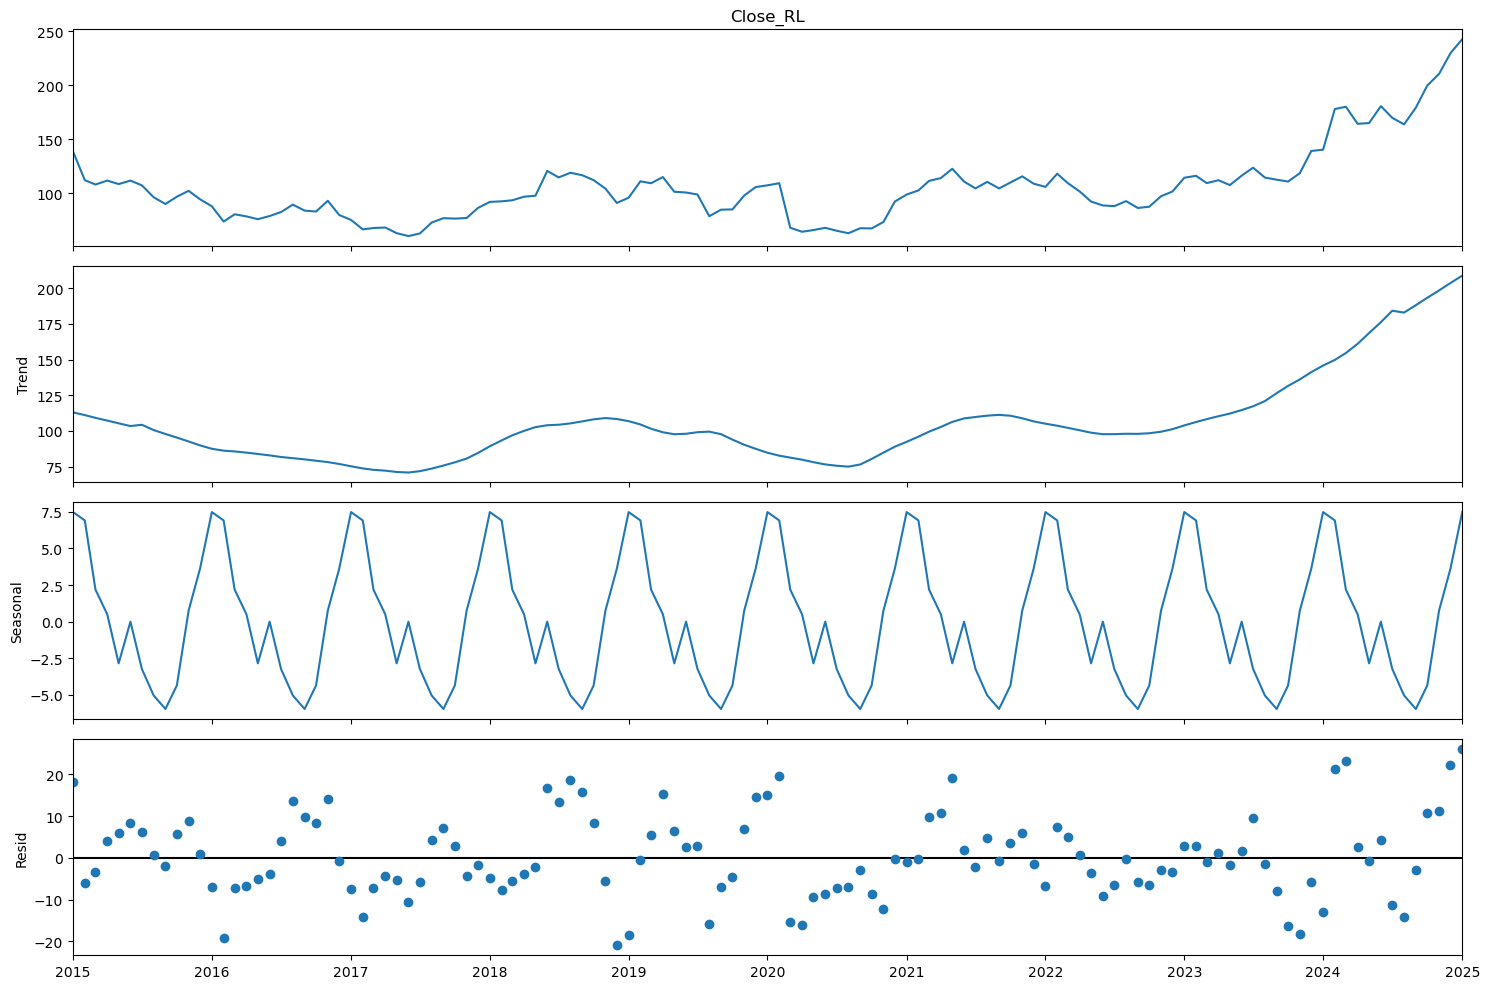

In [51]:
res = sm.tsa.seasonal_decompose(merged_data['Close_RL'], period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((15, 10))

fig.tight_layout()
plt.show()

### Identifying Correlations

In [52]:
print(np.corrcoef(merged_data['Close_RL'], merged_data['Imports']))
print(np.corrcoef(merged_data['Close_RL'], merged_data['Close_USDINR=X']))
print(np.corrcoef(merged_data['Close_RL'], merged_data['CCI']))

[[1.         0.68918119]
 [0.68918119 1.        ]]
[[1.         0.58682136]
 [0.58682136 1.        ]]
[[ 1.         -0.29428218]
 [-0.29428218  1.        ]]


<Axes: >

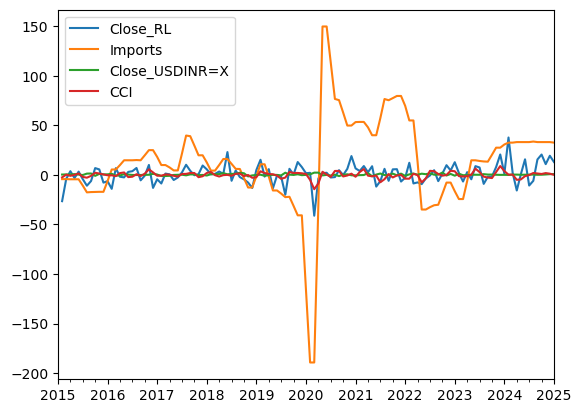

In [53]:
differenced_df = merged_data.diff()

differenced_df.plot()

In [54]:
print(np.corrcoef(differenced_df['Close_RL'].dropna(), differenced_df['Imports'].dropna()))
print(np.corrcoef(differenced_df['Close_RL'].dropna(), differenced_df['Close_USDINR=X'].dropna()))
print(np.corrcoef(differenced_df['Close_RL'].dropna(), differenced_df['CCI'].dropna()))

[[1.         0.27104023]
 [0.27104023 1.        ]]
[[ 1.        -0.2726598]
 [-0.2726598  1.       ]]
[[1.         0.46505625]
 [0.46505625 1.        ]]


##### Although the initial correlations looked promising, after finding the correlation between the differenced values, it is very evident that there is almost zero correlation between the chosen economic factors and the Ralph Lauren stock prices.

### Building the ETS Model

In [55]:
rl = merged_data[['Close_RL']]
rl.head()

,Close_RL
2015-01-01,138.620926
2015-02-01,112.042053
2015-03-01,108.028460
2015-04-01,111.664855
2015-05-01,108.440903


In [66]:
train_data, test_data = train_test_split(rl, test_size=12, random_state=42, shuffle=False)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 109
No. of testing examples: 12


In [67]:
train_data.head()

,Close_RL
2015-01-01,138.620926
2015-02-01,112.042053
2015-03-01,108.028460
2015-04-01,111.664855
2015-05-01,108.440903


In [68]:
test_data.head()

,Close_RL
2024-02-01,177.881973
2024-03-01,179.986862
2024-04-01,164.161913
2024-05-01,164.915878
2024-06-01,180.551575


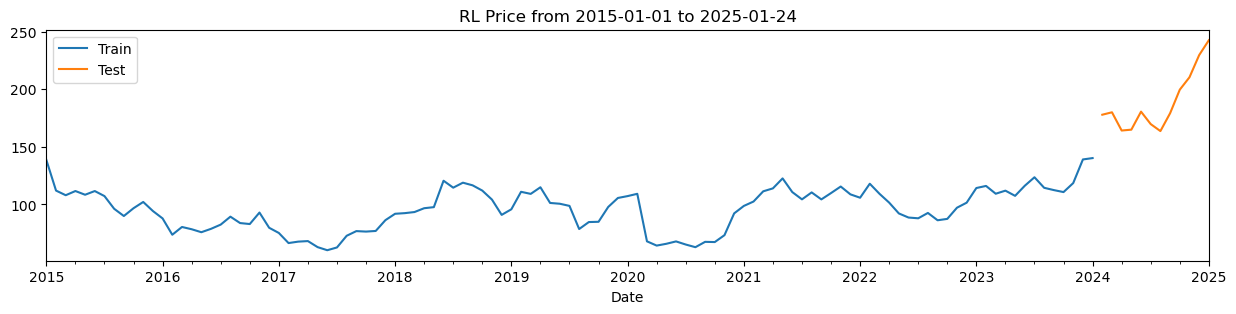

In [69]:
plt.figure(figsize=(15, 3))

train_data['Close_RL'].plot(label='Train')
test_data['Close_RL'].plot(label='Test')

plt.title('RL Price from {} to {}'.format('2015-01-01', '2025-01-24'))
plt.xlabel('Date')
plt.legend()

##### Single Exponential Smoothing

In [76]:
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])

In [77]:
ins_cast1.head()

2024-02-01    122.68759
2024-03-01    122.68759
2024-04-01    122.68759
2024-05-01    122.68759
2024-06-01    122.68759
Freq: MS, Name: alpha=0.2, dtype: float64

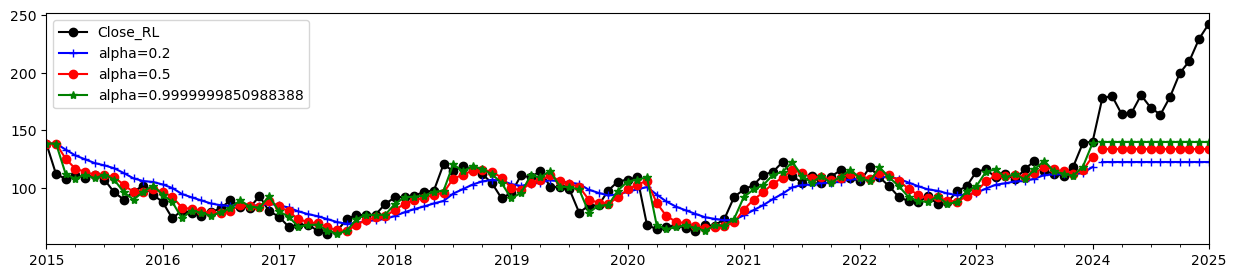

In [78]:
ax = rl.plot(marker='o', color='black', figsize=(15, 3), legend=True)

ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

##### Double Expopnential Smoothing

In [79]:
double_ets_add = ExponentialSmoothing(train_data, trend='add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend='mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)

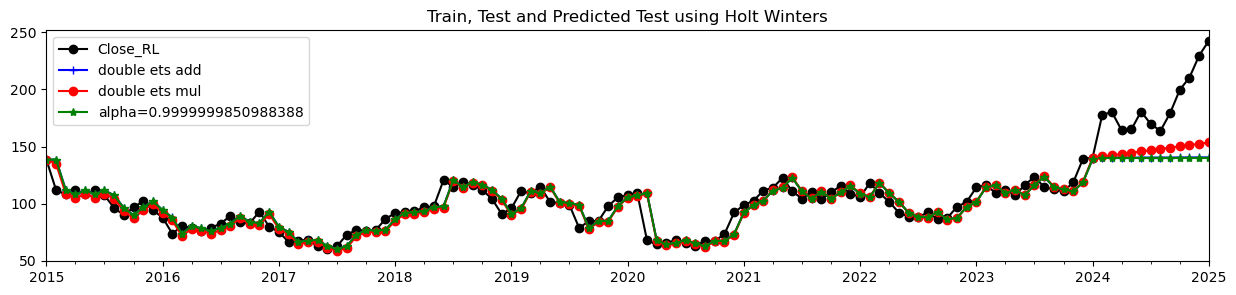

In [80]:
ax = rl.plot(marker='o', color='black', figsize=(15, 3), legend=True)

double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label='double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label='double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

##### Triple Exponential Smoothing

In [81]:
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


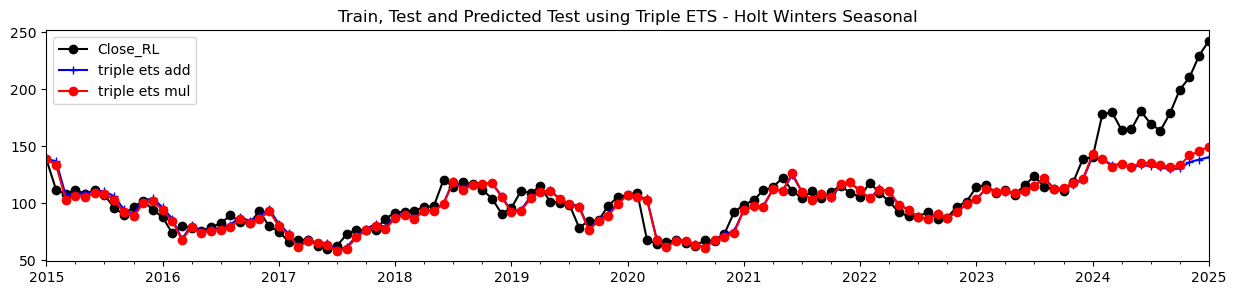

In [101]:
ax = rl.plot(marker='o', color='black', figsize=(15, 3), legend=True)

triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label='triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label='triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

In [84]:
test_data.head()

,Close_RL
2024-02-01,177.881973
2024-03-01,179.986862
2024-04-01,164.161913
2024-05-01,164.915878
2024-06-01,180.551575


In [85]:
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)

In [86]:
residuals.head()

,0
0,39.183396
1,46.257019
2,29.871651
3,33.671825
4,46.976775


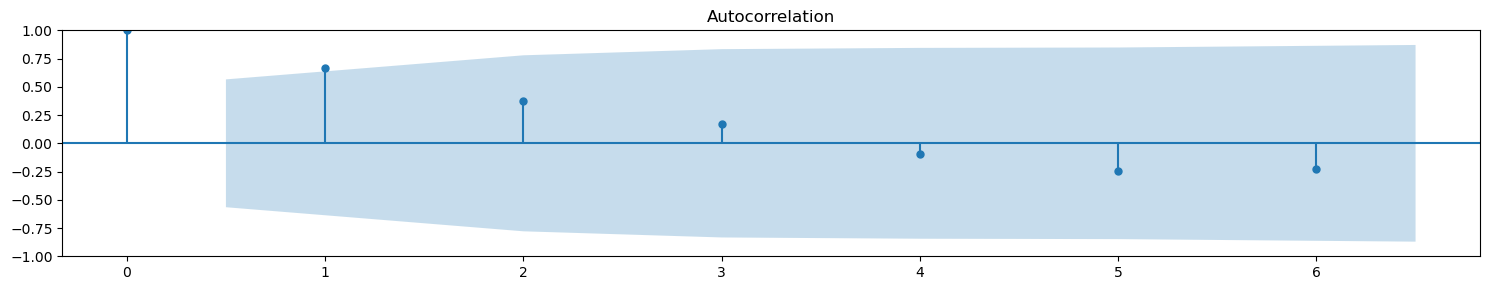

In [87]:
fig = plot_acf(residuals)
fig.set_size_inches((15, 3))

fig.tight_layout()
plt.show()

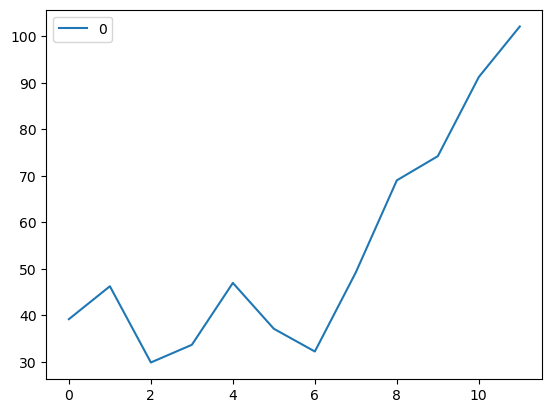

In [88]:
residuals.plot()
plt.show()

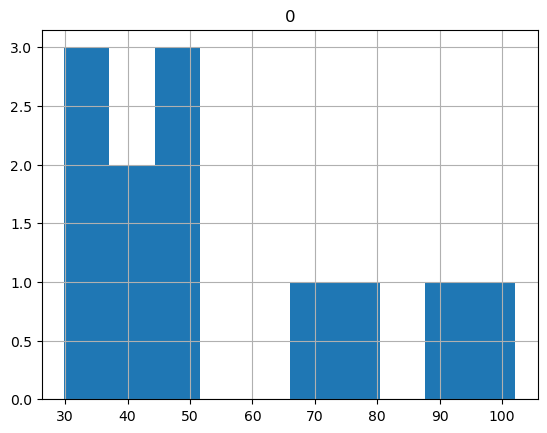

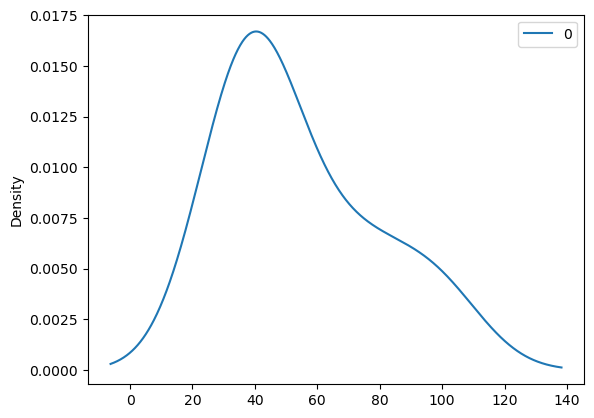

In [89]:
residuals.hist()
plt.show()

residuals.plot(kind='kde')
plt.show()

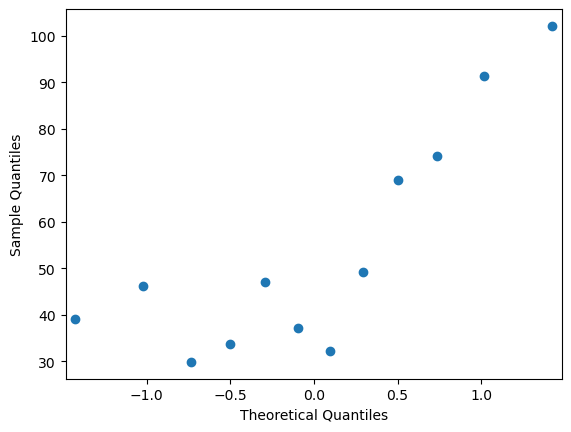

In [90]:
qqplot(residuals)
plt.show()

### Evaluating the Model's performance

In [91]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE', 'R²', 'SMAPE', 'MASE'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # R² (Coefficient of Determination)
    ss_total = np.sum((actuals - np.mean(actuals))**2)
    ss_residual = np.sum((actuals - predictions)**2)
    r2 = 1 - (ss_residual / ss_total)
    
    # SMAPE (Symmetric Mean Absolute Percentage Error)
    smape = 100 * np.mean(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))
    
    # MASE (Mean Absolute Scaled Error)
    naive_forecast = actuals[:-1]  # Lag-1 naive forecast
    mae_naive = np.mean(np.abs(actuals[1:] - naive_forecast))
    mase = mae / mae_naive

    df = pd.DataFrame({'Model': [model],
                       'RMSE': [rmse],
                       'MAE': [mae],
                       'MAPE': [mape],
                       'R²': [r2],
                       'SMAPE': [smape],
                       'MASE': [mase]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe

In [92]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast1.values.flatten(),
                                'Simple 0.2')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast2.values.flatten(),
                                'Simple 0.5')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast3.values.flatten(),
                                'Simple 1')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_add_pred.values.flatten(),
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_mul_pred.values.flatten(),
                                'Double Mul')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')

/var/folders/lx/x0t3rbk93g9_mdb6qn8w_d100000gn/T/ipykernel_2663/2751229754.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


In [93]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,R²,SMAPE,MASE
4,Double Mul,46.828954,41.153462,20.747214,-2.435177,23.636840,3.481319
3,Double Add,54.361922,48.156935,24.331446,-3.629242,28.339869,4.073768
2,Simple 1,54.477420,48.263947,24.386288,-3.648933,28.413641,4.082820
6,Triple Mul,55.402346,51.477509,26.430523,-3.808134,30.817226,4.354667
5,Triple Add,59.003482,54.264415,27.760264,-4.453503,32.729941,4.590421
1,Simple 0.5,60.279850,54.729147,27.871908,-4.691996,33.003711,4.629735
0,Simple 0.2,70.508679,65.826235,33.854743,-6.787632,41.330389,5.568477


In [94]:
rl.tail(368).mean()

Close_RL    105.308049
dtype: float64

In [95]:
triple_ets_add_pred.values.flatten()

array([138.69857703, 133.72984361, 134.29026207, 131.24405353,
       133.57479952, 132.62290412, 131.44591828, 129.90936327,
       130.57305501, 136.14494524, 138.34968476, 140.40951153])

In [96]:
test_pred_df = test_data.copy()

test_pred_df = test_pred_df.assign(triple_ets_mul_pred = triple_ets_mul_pred.values.flatten(),
                                   SimpleExp_1_pred = ins_cast3.values.flatten(),
                                   double_ets_mul_pred = double_ets_mul_pred.values.flatten())

test_pred_df.head()

,Close_RL,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred
2024-02-01,177.881973,139.172453,140.249878,141.313646
2024-03-01,179.986862,132.276440,140.249878,142.385482
2024-04-01,164.161913,134.609527,140.249878,143.465448
2024-05-01,164.915878,131.469062,140.249878,144.553605
2024-06-01,180.551575,135.682376,140.249878,145.650015


In [97]:
test_pred_df['Average_Predictions'] = (test_pred_df['SimpleExp_1_pred']+test_pred_df['triple_ets_mul_pred']+test_pred_df['double_ets_mul_pred'])/3

test_pred_df.head()

,Close_RL,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred,Average_Predictions
2024-02-01,177.881973,139.172453,140.249878,141.313646,140.245325
2024-03-01,179.986862,132.276440,140.249878,142.385482,138.303933
2024-04-01,164.161913,134.609527,140.249878,143.465448,139.441618
2024-05-01,164.915878,131.469062,140.249878,144.553605,138.757515
2024-06-01,180.551575,135.682376,140.249878,145.650015,140.527423


In [98]:
metrics_dataframe = metrics_cal(test_data.values.flatten(), test_pred_df['Average_Predictions'].values.flatten(), 'Average')

metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,R²,SMAPE,MASE
4,Double Mul,46.828954,41.153462,20.747214,-2.435177,23.636840,3.481319
7,Average,52.127646,46.964973,23.854675,-3.256538,27.567859,3.972935
3,Double Add,54.361922,48.156935,24.331446,-3.629242,28.339869,4.073768
2,Simple 1,54.477420,48.263947,24.386288,-3.648933,28.413641,4.082820
6,Triple Mul,55.402346,51.477509,26.430523,-3.808134,30.817226,4.354667
5,Triple Add,59.003482,54.264415,27.760264,-4.453503,32.729941,4.590421
1,Simple 0.5,60.279850,54.729147,27.871908,-4.691996,33.003711,4.629735
0,Simple 0.2,70.508679,65.826235,33.854743,-6.787632,41.330389,5.568477


#### Other Evaluation Metrics
R²:
This gives a measure of how well the model fits the data. A higher R² value means that the model explains more of the variance in the data. A negative R² can indicate that the model is worse than a baseline mean model, which is helpful for identifying poor-fitting models. I chose this because it can adds insight into how well the model is capturing the data's patterns, beyond just the magnitude of errors. Observing the R² value, it seems as though the model is struggling to perform well.

SMAPE:
SMAPE measures percentage errors but in a symmetric way, meaning it treats over and under-predictions equally. Since this method is meant for dealing with data of different scales, it can provide a normalized view of accuracy. It can show if one model is systematically biased in its predictions. Looking at the SMAPE scores, it is at a reasonable range, although even smaller values would indicate an even better model.

MASE:
MASE is calulated by comparing the performance of a model to a simple naive forecasting method, which provides context for how much better or worse the model is compared to a baseline. It’s a strong indicator of whether the model adds value over a simple forecast, which is important when comparing models that might be overfitting or underperforming. A MASE value >1 generally indicates that the model is not performing well. A negative score for MASE means that it is performing better than the baseline model. Here, it again seems that the model is not doing well.

All evaluation metrics indicate the the Double ETS Multiplicative model performs the best.

#### Model Results

Double Mul:
This model performs the best overall in terms of every evaluation metric used, showing that it has the lowest errors in both absolute and percentage terms. Despite having a negative R², it is more accurate than others in its predictions. This model likely has a better balance of complexity and generalization, capturing patterns well without overfitting. 

Triple Mul:
This model performs the worst across most metrics, with high RMSE, MAE, MAPE, and SMAPE, and negative R². This could be due to the complexity of the model which might lead to overfitting of the data. This can ultimately cause large errors and high variance. It might not generalize well to new or unseen data.

In summary, Double Mul works best due to its lower error values. However, all models have a negative R² score, suggesting room for further improvement in capturing the underlying data patterns.